<h1 align="center"> <strong>üöÄ XGBoost - Complete Guide</strong> </h1>

This notebook provides a comprehensive introduction to XGBoost (eXtreme Gradient Boosting), covering:
- Algorithm overview and key concepts
- XGBoost's innovations and advantages
- Implementation using the XGBoost library
- Hyperparameter tuning
- Feature importance visualization
- Best practices and use cases

---

## **üìö 1. Import Libraries and Setup**

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Machine learning
from sklearn.datasets import make_classification, make_regression, load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_curve, auc,
    mean_squared_error, r2_score, mean_absolute_error
)

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor, plot_importance, plot_tree
from xgboost import plot_tree

# Visualization settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("‚úÖ Libraries imported successfully!")

‚úÖ Libraries imported successfully!


## **üöÄ 2. XGBoost Algorithm Overview**

XGBoost (eXtreme Gradient Boosting) is an optimized distributed gradient boosting library designed to be highly efficient, flexible, and portable. It was created by Tianqi Chen and has become the go-to algorithm for many Kaggle competitions and real-world applications.

### **Key Concepts**

XGBoost builds upon the principles of gradient boosting but introduces several key innovations:

1. **Regularization**: Built-in L1 (Lasso) and L2 (Ridge) regularization to prevent overfitting
2. **Tree Pruning**: Uses a max-depth parameter and prunes trees backward
3. **CART (Classification and Regression Trees)**: Uses CART rather than traditional decision trees
4. **Handling Missing Values**: Built-in handling of missing data
5. **Block Structure for Parallel Learning**: Optimized data structures and algorithms for parallel processing
6. **Cache Awareness**: Allocated internal buffers for fast computation

### **How XGBoost Works**

Like other gradient boosting methods, XGBoost builds trees sequentially, with each new tree correcting the errors of the previous ensemble. The key steps are:

1. **Start** with an initial prediction (usually 0.5 for binary classification)
2. **For each iteration t = 1, 2, ..., T**:
   - Calculate gradients and hessians of the loss function
   - Build a tree that optimizes for these gradients
   - Perform leaf-wise growth rather than level-wise
   - Apply regularization during tree construction
   - Add the predictions from the new tree (scaled by learning rate) to the ensemble
3. **Final prediction**: Sum of all tree outputs (scaled by learning rate)

### **Mathematical View**

XGBoost optimizes the following objective function:

$$\text{Obj} = \sum_{i=1}^n l(y_i, \hat{y}_i) + \sum_{k=1}^K \Omega(f_k)$$

Where:
- $l$ is the loss function
- $\Omega$ is the regularization term
- $f_k$ represents each tree in the ensemble

The regularization term is defined as:

$$\Omega(f) = \gamma T + \frac{1}{2}\lambda ||w||^2$$

Where:
- $T$ is the number of leaves in the tree
- $w$ are the leaf weights
- $\gamma$ and $\lambda$ are regularization parameters

### **XGBoost vs. Traditional Gradient Boosting**

| Feature | XGBoost | Traditional Gradient Boosting |
|---------|---------|-----------------|
| **Regularization** | Built-in L1 and L2 | Limited or none |
| **Speed** | Highly optimized | Generally slower |
| **Missing Values** | Built-in handling | Requires preprocessing |
| **Tree Growth** | Grows leaf-wise | Grows level-wise |
| **Parallelization** | Highly parallelized | Limited or none |
| **Early Stopping** | Built-in support | May require custom implementation |

## **üìä 3. Use Cases and When to Use XGBoost**

### **Ideal Use Cases**

XGBoost excels in the following scenarios:

- **Structured/tabular data**: One of the best algorithms for structured data
- **Kaggle competitions**: Dominant algorithm in many data science competitions
- **Production environments**: Highly optimized for real-world applications
- **Medium to large datasets**: Scales well to substantial data sizes
- **Diverse problem types**: Classification, regression, ranking, etc.
- **When performance matters**: When you need high predictive accuracy

### **When to Use XGBoost vs. Other Algorithms**

- **Use XGBoost when**:
  - You need state-of-the-art performance on structured data
  - You have a mix of categorical and numerical features
  - Your data has missing values
  - You need both performance and reasonable training speed
  - You want a well-established, battle-tested algorithm

- **Consider alternatives when**:
  - Training speed is critical (‚Üí LightGBM)
  - You have a lot of categorical features (‚Üí CatBoost)
  - You need a simpler, more interpretable model (‚Üí Decision Trees, Linear Models)
  - You're working with unstructured data like images, text, or audio (‚Üí Deep Learning)

### **When NOT to Use XGBoost**

- **For very small datasets**: May overfit with too few examples
- **When explainability is paramount**: While feature importance helps, the model itself is a black box
- **For extremely large-scale problems**: While optimized, may still be outperformed by LightGBM for massive datasets
- **For unstructured data**: Not designed for images, text, audio (without feature engineering)
- **When training speed is the top priority**: LightGBM is often faster
- **For streaming/online learning**: Not designed for incremental learning

## **üìä 4. Generate Sample Data**

In [2]:
# Generate a synthetic classification dataset
X, y = make_classification( n_samples=1000,  n_features=20,  n_informative=10,  n_redundant=5,  n_classes=2,  random_state=42)

# Create a DataFrame for better visualization
feature_names = [f'feature_{i}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Dataset shape: (1000, 21)

First 5 rows:


feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   1.470848  -0.360450  -0.591602  -0.728228   0.941690   1.065964   
1   4.513369  -2.227103  -1.140747   2.018263  -2.238358  -0.497370   
2  -2.355643   2.218601  -1.603269   0.873394   0.401483   0.717264   
3  -1.596198  -0.857427   1.772434  -0.639361   1.419409  -0.438525   
4   2.840049  -2.489600  -0.844902  -1.594362  -4.688517   0.459637   

   feature_6  feature_7  feature_8  feature_9  ...  feature_11  feature_12  \
0   0.017832  -0.596184   1.840712  -1.497093  ...   -0.603968    2.899256   
1   0.714550   0.938883  -2.395169   0.159837  ...    1.461499    3.954171   
2  -0.859399  -1.042190  -2.175965   0.980231  ...    0.544434   -2.466258   
3   0.281949   2.345145   1.006230   0.389135  ...   -1.025051   -2.422975   
4   0.913607  -1.143505   1.263937  -2.040928  ...    4.176424    1.341742   

   feature_13  feature_14  feature_15  feature_16  feature_17  feature_18  \
0    0.037567   -1.249523    0.257963    0.416628    1.408208   -1.838041   
1    0.309054    0.538184   -7.157865   -4.532216   -0.081800   -9.325362   
2   -0.470256    0.073018   -2.203531   -2.299263   -1.742761   -0.271579   
3    1.579807   -0.300713    4.267120    2.893775    1.236697    6.034785   
4    0.133565    1.743819    1.531188    2.269808    0.053489   -3.151109   

   feature_19  target  
0   -0.833142       1  
1    0.574386       1  
2   -0.359285       0  
3   -0.045711       0  
4    1.603702       0  

[5 rows x 21 columns]

## **üîß 5. Implementing XGBoost**

XGBoost can be used in two main ways:
1. The sklearn-compatible API (XGBClassifier, XGBRegressor)
2. The native XGBoost API with DMatrix objects

We'll demonstrate both approaches.

### **5.1 Classification Example - Sklearn API**

Training time: 0.21 seconds

--- XGBoost Classification Results (sklearn API) ---
Accuracy: 0.9200

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       133
           1       0.89      0.95      0.92       117

    accuracy                           0.92       250
   macro avg       0.92      0.92      0.92       250
weighted avg       0.92      0.92      0.92       250



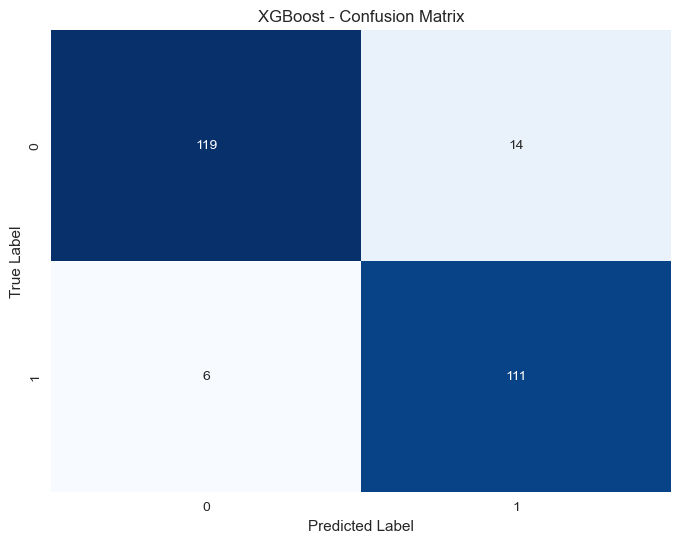

In [3]:
# Create and train XGBoost Classifier (sklearn API)
xgb_clf = XGBClassifier(
    n_estimators=100,            # Number of trees
    learning_rate=0.1,           # Learning rate
    max_depth=5,                 # Maximum tree depth
    min_child_weight=1,          # Minimum sum of instance weights in a child
    gamma=0,                     # Minimum loss reduction for further partition
    subsample=0.8,               # Subsample ratio of training instances
    colsample_bytree=0.8,        # Subsample ratio of columns for each tree
    objective='binary:logistic', # Binary classification
    eval_metric='error',         # Evaluation metric
    random_state=42
)

# Train the model
start_time = time.time()
xgb_clf.fit( X_train,  y_train,  eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")

# Make predictions
y_pred = xgb_clf.predict(X_test)
y_prob = xgb_clf.predict_proba(X_test)[:, 1]  # Probability for class 1

# Evaluate the model
print("\n--- XGBoost Classification Results (sklearn API) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('XGBoost - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

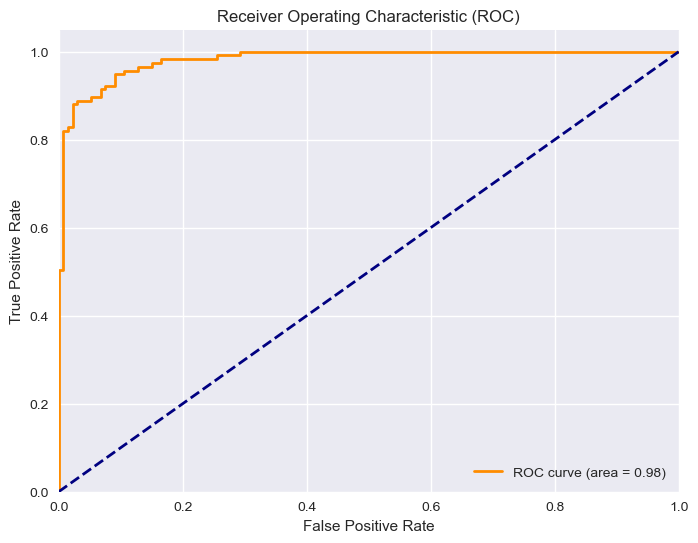

In [4]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### **5.2 Classification Example - Native XGBoost API**

The native API offers more flexibility and potentially better performance but is slightly more complex.

In [5]:
# Convert data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test, label=y_test)

# Set parameters
params = {
    'objective'        : 'binary:logistic',
    'eval_metric'      : 'error',
    'max_depth'        : 5,
    'eta'              : 0.1,  # learning_rate
    'subsample'        : 0.8,
    'colsample_bytree' : 0.8,
    'min_child_weight' : 1,
    'gamma'            : 0,
    'seed'             : 42
}

# Set up evaluation list
evallist = [(dtrain, 'train'), (dtest, 'eval')]

# Train the model using native API
start_time = time.time()
model = xgb.train(
    params, 
    dtrain, 
    num_boost_round=100,  # n_estimators equivalent
    evals=evallist,
    verbose_eval=False
)
native_training_time = time.time() - start_time
print(f"Training time (native API): {native_training_time:.2f} seconds")

# Make predictions
y_pred_native = model.predict(dtest) > 0.5  # Threshold for binary classification
y_prob_native = model.predict(dtest)

# Evaluate the model
print("\n--- XGBoost Classification Results (Native API) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_native):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_native.astype(int)))

Training time (native API): 0.16 seconds

--- XGBoost Classification Results (Native API) ---
Accuracy: 0.9200

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       133
           1       0.89      0.95      0.92       117

    accuracy                           0.92       250
   macro avg       0.92      0.92      0.92       250
weighted avg       0.92      0.92      0.92       250



### **5.3 Regression Example**

Training time: 0.21 seconds

--- XGBoost Regression Results ---
R¬≤ Score: 0.9201
Mean Squared  Error: 2917.94
Mean Absolute Error: 43.19


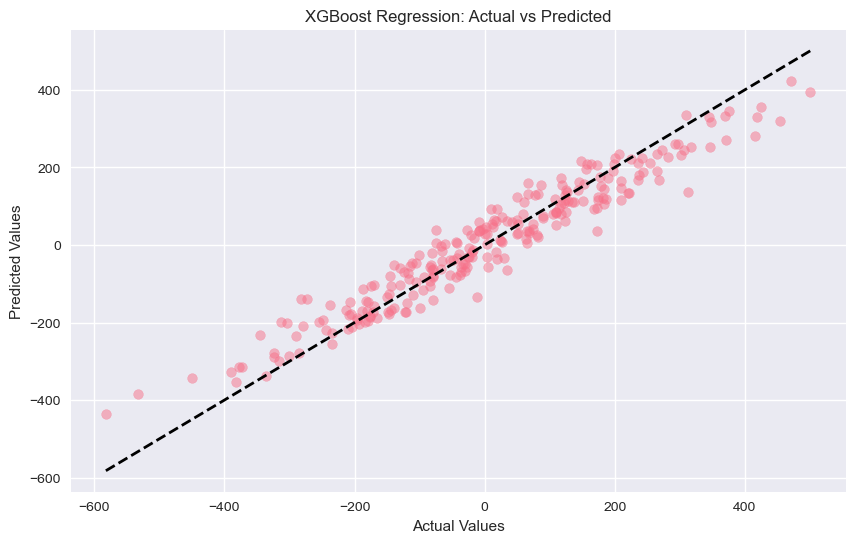

In [6]:
# Generate a synthetic regression dataset
X_reg, y_reg = make_regression( n_samples=1000,  n_features=20,  n_informative=10, noise=0.1, random_state=42 )

# Split the regression data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.25, random_state=42)

# Create and train an XGBoost Regressor
xgb_reg = XGBRegressor( n_estimators=100, learning_rate=0.1, max_depth=5, subsample=0.8, colsample_bytree=0.8, objective='reg:squarederror',  random_state=42)

# Train the model
start_time = time.time()
xgb_reg.fit( X_train_reg,  y_train_reg,  eval_set=[(X_test_reg, y_test_reg)], verbose=False)
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")

# Make predictions
y_pred_reg = xgb_reg.predict(X_test_reg)

# Evaluate the model
print("\n--- XGBoost Regression Results ---")
print(f"R¬≤ Score: {r2_score(y_test_reg, y_pred_reg):.4f}")
print(f"Mean Squared  Error: {mean_squared_error(y_test_reg, y_pred_reg):.2f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_reg, y_pred_reg):.2f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', lw=2)
plt.title('XGBoost Regression: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

### **5.4 Multi-Class Classification Example**

XGBoost can also handle multi-class problems effectively.

--- XGBoost Multi-Class Classification Results ---
Accuracy: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



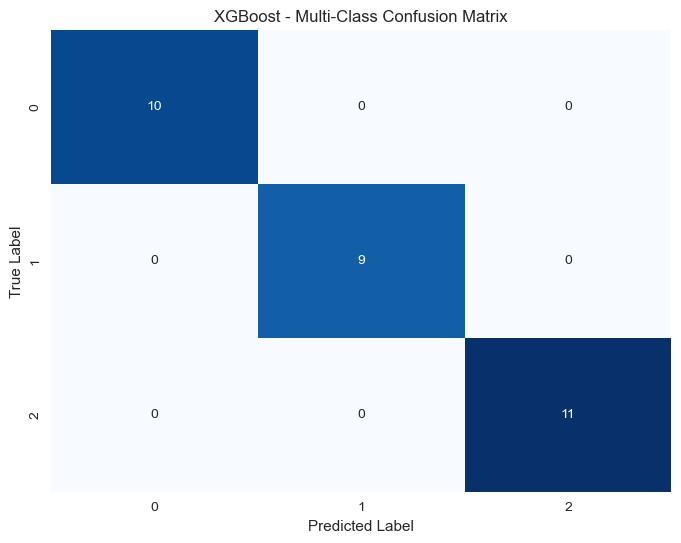

In [7]:
# Load iris dataset (multi-class)
iris = load_iris()
X_iris, y_iris = iris.data, iris.target

# Train-test split
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X_iris, y_iris, test_size=0.2, random_state=42)

# Create XGBoost classifier for multi-class classification
xgb_multi = XGBClassifier( n_estimators=100, learning_rate=0.1, max_depth=3, objective='multi:softprob',  num_class=3, random_state=42)

# Train the model
xgb_multi.fit(X_train_iris, y_train_iris)

# Make predictions
y_pred_iris = xgb_multi.predict(X_test_iris)

# Evaluate
print("--- XGBoost Multi-Class Classification Results ---")
print(f"Accuracy: {accuracy_score(y_test_iris, y_pred_iris):.3f}")
print("\nClassification Report:")
print(classification_report(y_test_iris, y_pred_iris))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm_iris = confusion_matrix(y_test_iris, y_pred_iris)
sns.heatmap(cm_iris, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('XGBoost - Multi-Class Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## **üîç 6. Key Hyperparameters Explained**

XGBoost has numerous hyperparameters that control model behavior and performance. They can be divided into several categories:

### **General Parameters**

| üìå **Parameter** | üìù **Description** | üîß **Typical Values** | üí° **Impact** |
| --------------- | ------------------ | -------------------- | ------------ |
| **booster** | Booster type to use | 'gbtree', 'gblinear', 'dart' | 'gbtree' is most common, 'dart' for Dropout |
| **objective** | Defines the loss function | 'binary:logistic', 'reg:squarederror', 'multi:softmax' | Depends on problem type |
| **num_class** | Number of classes | integer | Required for multi-class problems |
| **eval_metric** | Evaluation metric | 'error', 'rmse', 'logloss', 'auc' | Depends on objective |

### **Booster Parameters**

| üìå **Parameter** | üìù **Description** | üîß **Typical Values** | üí° **Impact** |
| --------------- | ------------------ | -------------------- | ------------ |
| **n_estimators / num_boost_round** | Number of trees | 100-1000 | Higher values may improve performance |
| **learning_rate / eta** | Step size shrinkage | 0.01-0.3 | Lower values need more trees |
| **max_depth** | Maximum tree depth | 3-10 | Higher values increase complexity |
| **min_child_weight** | Minimum sum of instance weights | 1-10 | Higher values prevent overfitting |
| **gamma** | Minimum loss reduction | 0-0.5 | Higher values make algorithm more conservative |
| **subsample** | Subsample ratio | 0.5-1.0 | < 1.0 prevents overfitting |
| **colsample_bytree** | Column subsample ratio | 0.5-1.0 | < 1.0 prevents overfitting |
| **alpha** | L1 regularization | 0-1.0 | Higher values increase regularization |
| **lambda** | L2 regularization | 0-1.0 | Higher values increase regularization |

### **Learning Task Parameters**

| üìå **Parameter** | üìù **Description** | üîß **Typical Values** | üí° **Impact** |
| --------------- | ------------------ | -------------------- | ------------ |
| **scale_pos_weight** | Weight of positive class | 1.0 or sum(neg)/sum(pos) | Helps with imbalanced classes |
| **base_score** | Initial prediction score | 0.5 | Global bias |
| **early_stopping_rounds** | Stops if no improvement | 10-50 | Prevents overfitting and saves time |

### **XGBoost-Specific Features**

- **GPU Acceleration**: Set `tree_method='gpu_hist'` for GPU training
- **Monotonic Constraints**: Control if features have monotonic relationship with target
- **Feature Interaction Constraints**: Limit which features can interact in trees
- **Missing Value Handling**: Automatically handles missing values (set to None or np.nan)
- **Custom Objective Functions**: Support for custom loss functions

## **üîÑ 7. Hyperparameter Tuning**

In [8]:
# Define parameter grid for tuning
param_grid = {
    'n_estimators'      : [50, 100, 200],
    'learning_rate'     : [0.01, 0.1, 0.2],
    'max_depth'         : [3, 5, 7],
    'min_child_weight'  : [1, 3, 5],
    'subsample'         : [0.6, 0.8, 1.0],
    'colsample_bytree'  : [0.6, 0.8, 1.0],
    'gamma'             : [0, 0.1, 0.2]
}

# Using RandomizedSearchCV instead of GridSearchCV to speed up the process
# In practice, you might want to do a staged approach (coarse search, then fine-tuning)
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(objective='binary:logistic', random_state=42),
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit the randomized search
print("Starting randomized search...")
random_search.fit(X_train, y_train)

# Display best parameters and score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_:.4f}")

# Create a model with the best parameters
best_xgb = random_search.best_estimator_

# Evaluate on the test set
best_predictions = best_xgb.predict(X_test)
print(f"Test accuracy with best parameters: {accuracy_score(y_test, best_predictions):.4f}")

Starting randomized search...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 50, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}
Best cross-validation score: 0.9347
Test accuracy with best parameters: 0.9280


## **üìä 8. Early Stopping**

Early stopping is a powerful technique to prevent overfitting and save training time.

Best iteration: 42
Accuracy with early stopping: 0.8840


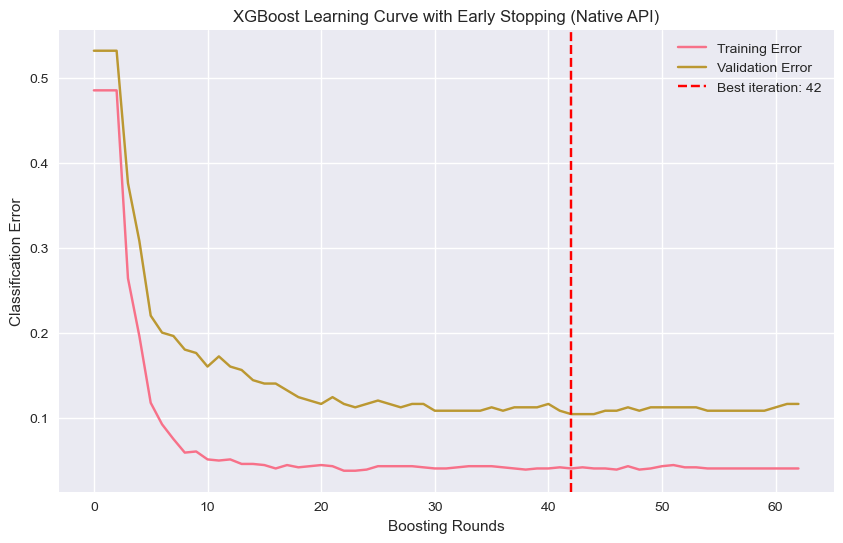

In [9]:
# Define model
xgb_es = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='error',
    random_state=42
)

# Try the most universal approach - using the native XGBoost API
# First convert data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test, label=y_test)

# Set parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'error',
    'max_depth': 5,
    'eta': 0.01,  # learning_rate
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Set up evaluation list
evallist = [(dtrain, 'train'), (dtest, 'eval')]

# Prepare an empty dict to store evaluation history
evals_result = {}

# Train with early stopping and store evaluation log
model_es = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evallist,
    early_stopping_rounds=20,
    evals_result=evals_result,   # ‚úÖ This is the key!
    verbose_eval=False
)

# Get the best iteration
best_iteration = model_es.best_iteration
print(f"Best iteration: {best_iteration}")
print(f"Accuracy with early stopping: {accuracy_score(y_test, model_es.predict(dtest) > 0.5):.4f}")

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(evals_result['train']['error'], label='Training Error')
plt.plot(evals_result['eval']['error'], label='Validation Error')
plt.axvline(x=best_iteration, color='r', linestyle='--', label=f'Best iteration: {best_iteration}')
plt.xlabel('Boosting Rounds')
plt.ylabel('Classification Error')
plt.title('XGBoost Learning Curve with Early Stopping (Native API)')
plt.legend()
plt.grid(True)
plt.show()

## **üìä 9. Feature Importance Visualization**

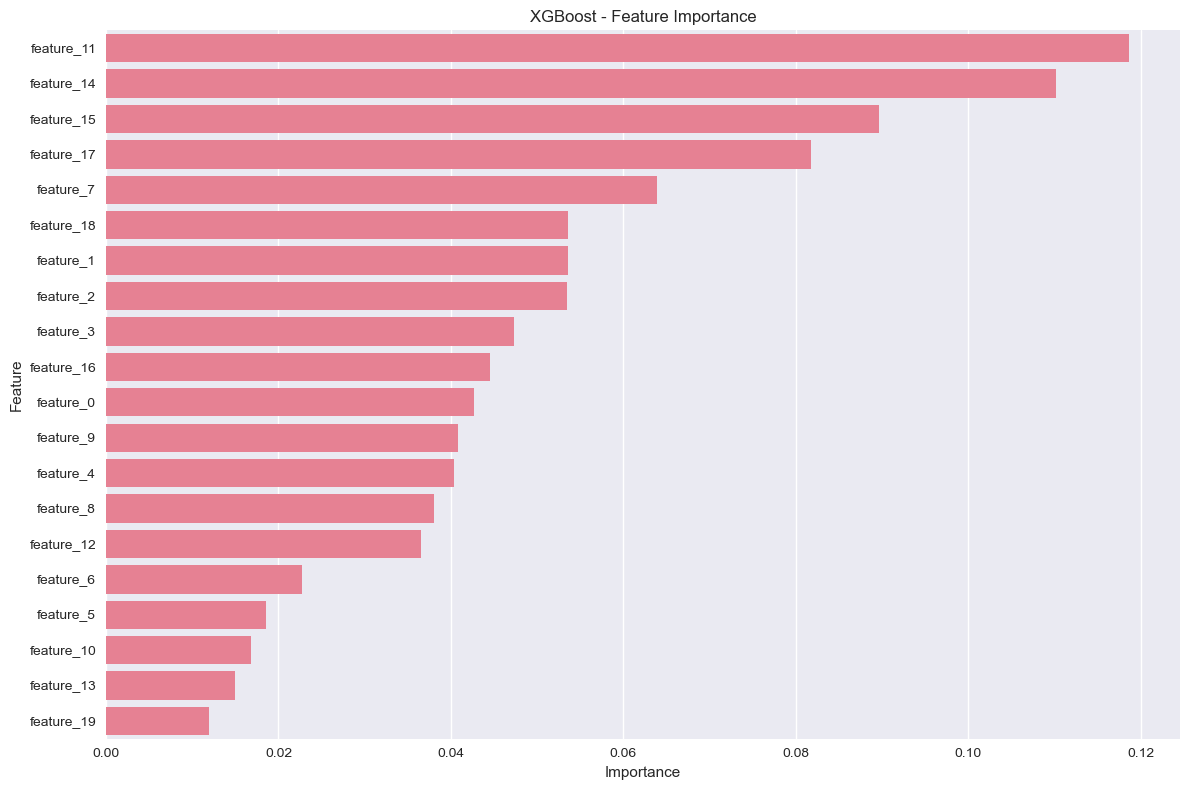

Top 10 Most Important Features:


Feature  Importance
11  feature_11    0.118617
14  feature_14    0.110185
15  feature_15    0.089622
17  feature_17    0.081801
7    feature_7    0.063953
18  feature_18    0.053624
1    feature_1    0.053606
2    feature_2    0.053484
3    feature_3    0.047293
16  feature_16    0.044515

In [10]:
# Get feature importances from the trained model
feature_importances = xgb_clf.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('XGBoost - Feature Importance')
plt.tight_layout()
plt.show()

# Print top 10 features
print("Top 10 Most Important Features:")
display(importance_df.head(10))

<Figure size 1200x800 with 0 Axes>

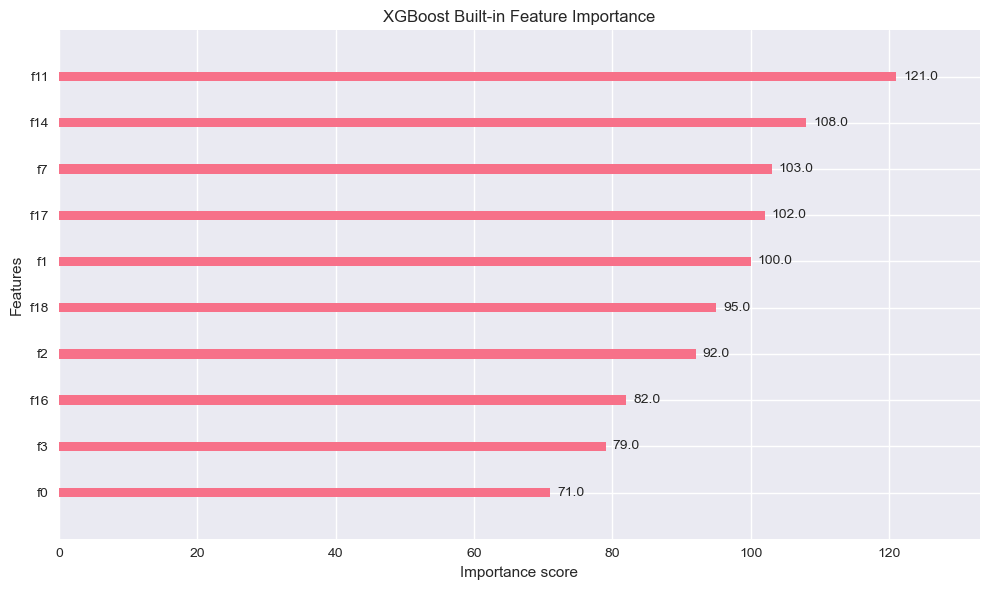

In [11]:
# XGBoost also provides built-in visualization functions
plt.figure(figsize=(12, 8))
plot_importance(xgb_clf, max_num_features=10)
plt.title('XGBoost Built-in Feature Importance')
plt.tight_layout()
plt.show()

## **üå≥ 10. Visualizing Trees**

XGBoost allows us to visualize the individual trees in the ensemble.

<Figure size 2000x1000 with 0 Axes>

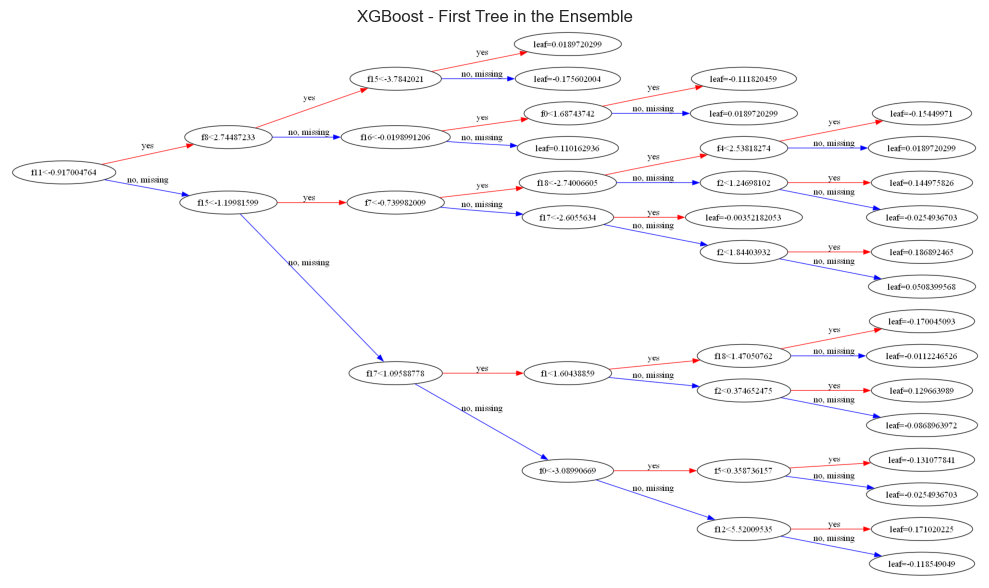

In [12]:
plt.figure(figsize=(20, 10))
plot_tree(xgb_clf, num_trees=0, rankdir='LR')
plt.title('XGBoost - First Tree in the Ensemble')
plt.tight_layout()
plt.show()

## üå≥ How to Enable XGBoost Tree Visualization (Graphviz Fix)

To visualize trees in XGBoost using `plot_tree()` or `to_graphviz()`, you need **Graphviz** installed and properly set up.

### ‚úÖ Steps (Windows):

1. **Download Graphviz**  
   Go to the official site:  
   üëâ https://graphviz.org/download/

2. **Install it**  
   Run the installer (e.g., `.exe` or `.msi`)  
   Default path:  
```

C:\Program Files\Graphviz

````

3. **Add Graphviz to PATH**  
- Open **Start** ‚Üí search ‚ÄúEnvironment Variables‚Äù
- Go to **System Variables** ‚Üí Edit `Path`
- Add:
  ```
  C:\Program Files\Graphviz\bin
  ```

4. **Verify it's working**  
Open Command Prompt and run:
```bash
dot -V
````

Should return version info like:

```
dot - graphviz version 2.X.X (date)
```

5. **Restart your IDE / Jupyter Notebook**

## **üí° 11. Advanced Features**

### **11.1 Handling Missing Values**

In [13]:
# Create a copy of the data and introduce missing values
X_train_missing = X_train.copy()
X_test_missing = X_test.copy()

# Introduce 10% missing values randomly
mask_train = np.random.rand(*X_train_missing.shape) < 0.1
mask_test = np.random.rand(*X_test_missing.shape) < 0.1
X_train_missing[mask_train] = np.nan
X_test_missing[mask_test] = np.nan

print(f"Number of missing values in training data: {np.isnan(X_train_missing).sum()}")

# Train XGBoost with missing values
xgb_missing = XGBClassifier(n_estimators=100,learning_rate=0.1,max_depth=5,subsample=0.8,random_state=42)

# XGBoost handles missing values automatically
xgb_missing.fit(X_train_missing, y_train)
y_pred_missing = xgb_missing.predict(X_test_missing)

print(f"Accuracy with missing values: {accuracy_score(y_test, y_pred_missing):.4f}")

Number of missing values in training data: 1500
Accuracy with missing values: 0.8880


### **11.2 Cross-Validation**

In [14]:
# Perform cross-validation with XGBoost
xgb_cv = XGBClassifier(n_estimators=100,learning_rate=0.1,max_depth=5,subsample=0.8,random_state=42)

# Cross-validation with 5 folds
cv_scores = cross_val_score(xgb_cv, X, y, cv=5, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} ¬± {cv_scores.std():.4f}")

Cross-validation scores: [0.935 0.925 0.94  0.905 0.955]
Mean CV accuracy: 0.9320 ¬± 0.0166


### **11.3 Native API Cross-Validation**

XGBoost's native API also provides a powerful cross-validation function.

Cross-Validation Results:
    train-error-mean  train-error-std  test-error-mean  test-error-std
36           0.00800         0.001275            0.076        0.020591
37           0.00800         0.001000            0.074        0.018815
38           0.00700         0.000612            0.074        0.024372
39           0.00675         0.000612            0.072        0.023791
40           0.00625         0.000791            0.071        0.022226


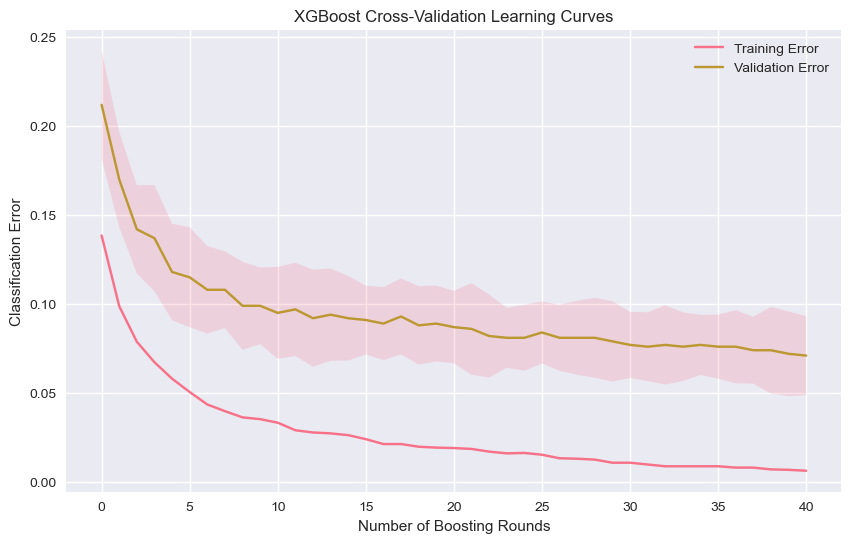

In [15]:
# Convert all data to DMatrix format
dtrain_full = xgb.DMatrix(X, label=y)

# Parameters
params = {
    'objective'         : 'binary:logistic',
    'eval_metric'       : 'error',
    'max_depth'         : 5,
    'eta'               : 0.1,
    'subsample'         : 0.8,
    'colsample_bytree'  : 0.8
}

# Run cross-validation
cv_results = xgb.cv( params,  dtrain_full,  num_boost_round=100,  nfold=5,  metrics='error', early_stopping_rounds=20, seed=42)

# Display results
print("Cross-Validation Results:")
print(cv_results.tail(5))

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(cv_results['train-error-mean'], label='Training Error')
plt.plot(cv_results['test-error-mean'], label='Validation Error')
plt.fill_between(
    range(len(cv_results['test-error-mean'])),
    cv_results['test-error-mean'] - cv_results['test-error-std'],
    cv_results['test-error-mean'] + cv_results['test-error-std'],
    alpha=0.2
)
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Classification Error')
plt.title('XGBoost Cross-Validation Learning Curves')
plt.legend()
plt.grid(True)
plt.show()

## **üí° 12. Best Practices and Tips**

### **When to Choose XGBoost**

- **For tabular data**: Consistently top performer
- **When performance is crucial**: Often wins competitions
- **For a balance of speed and accuracy**: Faster than traditional GBM but more accurate
- **When you need regularization**: Built-in regularization techniques
- **When you have missing values**: Native handling of missing data
- **For production environments**: Well-optimized and scalable

### **Tuning Strategy**

1. **Start with defaults**, then tune in this order:

   a. **Basic parameters**:
      - Set `n_estimators` high (1000+) with early stopping
      - Start with `learning_rate` = 0.1

   b. **Tree parameters** (control model complexity):
      - `max_depth` (3-10)
      - `min_child_weight` (1-10)
   
   c. **Randomness parameters** (reduce overfitting):
      - `subsample` (0.5-1.0)
      - `colsample_bytree` (0.5-1.0)
   
   d. **Regularization parameters**:
      - `gamma` (0-0.5)
      - `alpha` and `lambda` (0-1.0)
   
2. **Decrease `learning_rate`** and increase `n_estimators` as final step

3. **Always use early stopping** to find optimal number of trees

### **Practical Advice**

- **Use native API** for large datasets and more control
- **Scale features** for linear boosters but not for tree-based ones
- **Handle class imbalance** with `scale_pos_weight`
- **Save memory** by using `gpu_hist` tree method on GPU
- **Efficient hyperparameter tuning**:
  - Use RandomizedSearchCV for initial exploration
  - Fine-tune with GridSearchCV on promising regions

### **Common Pitfalls**

- **Overfitting**: Lower max_depth, increase min_child_weight
- **Underfitting**: Increase depth, decrease min_child_weight
- **Training too long**: Use early stopping
- **Memory issues**: Reduce max_depth, use histogram-based tree method
- **Ignoring categorical features**: One-hot encode or use CatBoost instead
- **Not handling imbalanced data**: Adjust scale_pos_weight

## **üîÑ 13. Comparison with Other Boosting Algorithms**

| Algorithm | Strengths | Weaknesses | Best Use Case |
|-----------|-----------|------------|---------------|
| **XGBoost** | All-around performer, regularization, handles missing values | Memory usage, needs tuning | General tabular data problems |
| **LightGBM** | Very fast, handles large datasets, leaf-wise growth | Less accurate on small datasets | Very large datasets, when speed matters |
| **CatBoost** | Great for categorical features, less overfitting | Can be slower | Datasets with many categorical features |
| **Sklearn GBM** | Simple interface, good for learning | Slower, less optimized | Learning gradient boosting concepts |

## **üìö 14. Additional Resources**

### **Official Documentation**

- [XGBoost Documentation](https://xgboost.readthedocs.io/)
- [XGBoost Parameters](https://xgboost.readthedocs.io/en/latest/parameter.html)
- [XGBoost Tutorials](https://xgboost.readthedocs.io/en/latest/tutorials/index.html)

### **Papers and Articles**

- [XGBoost: A Scalable Tree Boosting System](https://arxiv.org/abs/1603.02754) - Original paper
- [Practical Hyperparameter Optimization](https://arxiv.org/abs/1810.05683) - Best practices for tuning

### **Tutorials and Courses**

- [Complete Guide to Parameter Tuning in XGBoost](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)
- [Feature Importance in XGBoost](https://medium.com/data-design/xgboost-hi-im-gamma-what-can-i-do-for-you-and-the-tuning-of-regularization-a42ea17e6ab6)

---

<h3 align="center">üöÄ Happy Modeling with XGBoost! üöÄ</h3>